<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Модель-линейной-регрессии" data-toc-modified-id="Модель-линейной-регрессии-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Модель линейной регрессии</a></span></li><li><span><a href="#Модель-случайного-леса" data-toc-modified-id="Модель-случайного-леса-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Модель случайного леса</a></span></li><li><span><a href="#Модель-дерева-решений" data-toc-modified-id="Модель-дерева-решений-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Модель дерева решений</a></span></li><li><span><a href="#Градиентный-бустинг-Catboost" data-toc-modified-id="Градиентный-бустинг-Catboost-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Градиентный бустинг Catboost</a></span></li><li><span><a href="#Градиентный-бустинг-LightGBM" data-toc-modified-id="Градиентный-бустинг-LightGBM-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Градиентный бустинг LightGBM</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Заказчиком предоставлены исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Построим модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Работа выполнена в несколько этапов:

1. Загрузка данных и их ресемплирование по одному часу.
2. Анализ данных.
3. Обучение разных моделей с различными гиперпараметрами.
4. Проверка данных на тестовой выборке и выводы.


В ходе работы выполнен прогноз заказов по временному ряду. Использованы библиотеки pandas, matplotlib, numpy, lightgbm, sklearn, catboost. Модели предсказания данных - дерево решений, случайный лес, линейная регрессия, Catboost, LightGBM. Ключевая метрика - MSE.

## Подготовка

Импортируем модули, которые нам понадобятся для дальнейшей работы.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split

Читаем базу данных.

In [ ]:
df = pd.read_csv('/datasets/taxi.csv', sep= ',')
display(df.head().T)
df.info()

,0,1,2,3,4
datetime,2018-03-01 00:00:00,2018-03-01 00:10:00,2018-03-01 00:20:00,2018-03-01 00:30:00,2018-03-01 00:40:00
num_orders,9,14,28,20,32


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26496 non-null object
num_orders    26496 non-null int64
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


Мы получили базу данных из 2 признаков: дата и одна целевая переменная. Всего в базе 26 496 записей. Данные не содержат пропуски и дубликаты. Названия столбцов соответствуют стандарту PEP8 и закодированы в "snake case".

Посмотрим на переменную заказов такси:

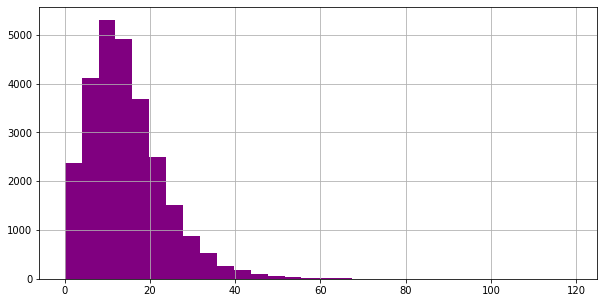

In [ ]:
df['num_orders'].hist(bins=30, color = 'Purple', figsize = (10,5))
None

Довольно существенная скошенность графика с правой стороны:

In [ ]:
np.percentile(df['num_orders'], np.arange(99,100,0.1))

array([43., 43., 44., 45., 47., 48., 50., 53., 56., 64.])

Менее 1% 10-минутных отрезков времени имеют более 43 заказов. И менее 0,1% - более 64 заказов. Т.к. мы в будущем будем ресемплировать данные по 1 часу, мы можем удалить эти выбросы, а потом взять среднее часа и, умножив на 6, получим заказы за средний час.

In [ ]:
df = df.query('num_orders <= 64')

Тип данных даты - текстовый, сменим его на дату:

In [ ]:
df['datetime'] =  pd.to_datetime(df['datetime'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26472 entries, 0 to 26495
Data columns (total 2 columns):
datetime      26472 non-null datetime64[ns]
num_orders    26472 non-null int64
dtypes: datetime64[ns](1), int64(1)
memory usage: 620.4 KB


Заменим индекс на столбец с датой. Проверим возрастание таблицы по индексу:

In [ ]:
df = df.set_index('datetime')
df.index.is_monotonic

True

Данные обработаны и готовы к анализу.

## Анализ

Посмотрим на полученную таблицу в графике:

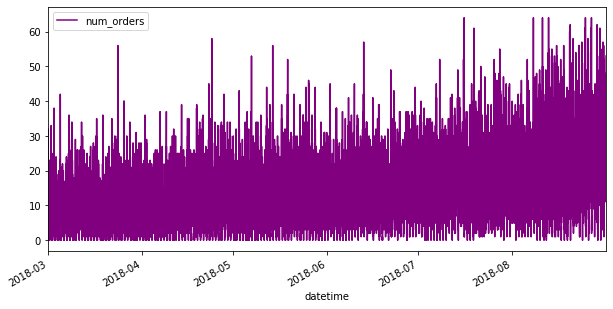

In [ ]:
df.plot(color = 'Purple', figsize = (10,5))
None

У Чётенького такси дела идут неплохо: похоже, что заказов со временем становится больше. Выполним ресемплирование данных по 1 часу, чтобы сгладить нестабильность основного показателя, как того требует ТЗ:

In [ ]:
df = df.resample('1H').mean()*6

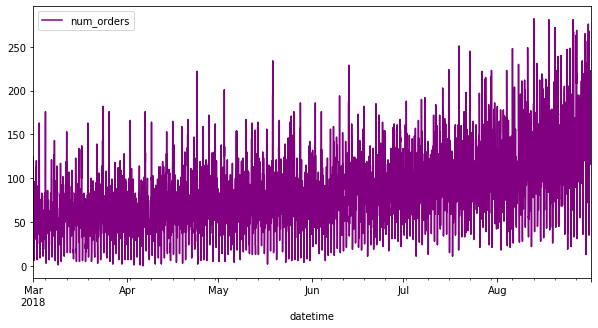

In [ ]:
df.plot(color = 'Purple', figsize = (10,5))
None

Теперь в нашем ряду цифры за средний час с марта по сентябрь 2018 года.

Добавим дополнительные признаки для формирования предсказаний - скользящее среднее с разными окнами.

In [ ]:
df['rolling_mean10'] = df['num_orders'].rolling(10).mean()
df['rolling_mean100'] = df['num_orders'].rolling(100).mean()
df['rolling_mean500'] = df['num_orders'].rolling(500).mean()

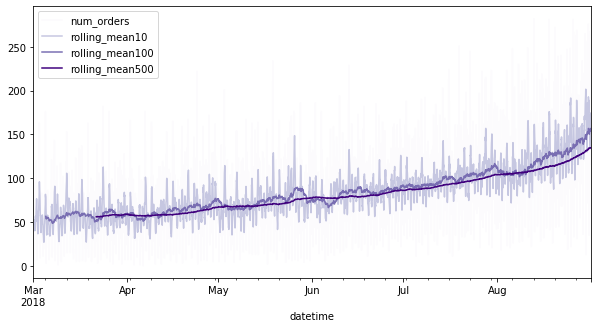

In [ ]:
df.plot(figsize = (10,5), colormap = 'Purples')
None

Есть тренд на увеличение заказов в целом, но прочей сезоннойсти, помимо суточной, не обнаружено. Суточная же сезонность достаточно строгая.

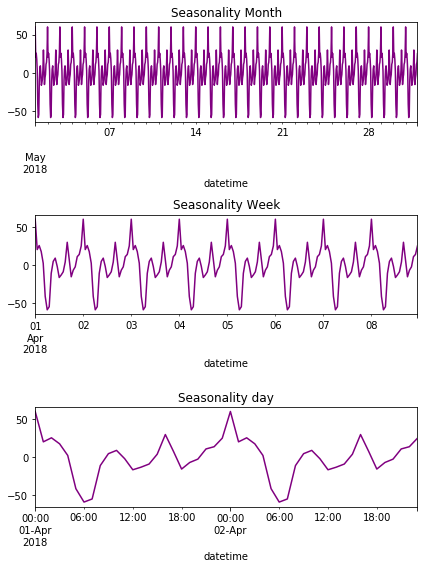

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposed = seasonal_decompose(df['num_orders'])

plt.figure(figsize=(6, 8))

plt.subplot(311)
decomposed.seasonal['2018-05-01':'2018-05-31'].plot(ax=plt.gca(), color = 'Purple')
plt.title('Seasonality Month')

plt.subplot(312)
decomposed.seasonal['2018-04-01':'2018-04-08'].plot(ax=plt.gca(), color = 'Purple')
plt.title('Seasonality Week')

plt.subplot(313)
decomposed.seasonal['2018-04-01':'2018-04-02'].plot(ax=plt.gca(), color = 'Purple')
plt.title('Seasonality day')

plt.tight_layout()

Это делает наш ряд нестационарным. Добавим признаки дня недели и часа (месяц и год нерелевантны из-за короткого периода анализа, внутри месяца нет изменений, что видно на графиках выше). Также добавим признаки среднего количества заказов со сдвигом.

In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean_shift'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 3, 10)
df

,num_orders,rolling_mean10,rolling_mean100,rolling_mean500,dayofweek,hour,lag_1,lag_2,lag_3,rolling_mean_shift
datetime,,,,,,,,,,
2018-03-01 00:00:00,124.0,NaN,NaN,NaN,3,0,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85.0,NaN,NaN,NaN,3,1,124.0,NaN,NaN,NaN
2018-03-01 02:00:00,71.0,NaN,NaN,NaN,3,2,85.0,124.0,NaN,NaN
2018-03-01 03:00:00,66.0,NaN,NaN,NaN,3,3,71.0,85.0,124.0,NaN
2018-03-01 04:00:00,43.0,NaN,NaN,NaN,3,4,66.0,71.0,85.0,NaN
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136.0,166.6,155.435,134.8394,4,19,207.0,217.0,197.0,173.3
2018-08-31 20:00:00,154.0,162.9,155.325,134.6494,4,20,136.0,207.0,217.0,166.6
2018-08-31 21:00:00,159.0,162.1,155.095,134.5154,4,21,154.0,136.0,207.0,162.9


## Обучение

Разделим выборку на тестовую и обучающую в соответствии с техническим заданием.

In [ ]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

### Модель линейной регрессии

In [ ]:
model = LinearRegression()
model.fit(train.drop(['num_orders'], axis=1), train['num_orders'])
pred_test = model.predict(test.drop(['num_orders'], axis=1))

current_model = pd.DataFrame({'Model': ['Linear Regression'],
              'RMSE, orders': mean_squared_error(test['num_orders'], pred_test)**0.5})
all_models = current_model.merge(current_model, how = 'outer')
all_models

,Model,"RMSE, orders"
0,Linear Regression,31.914712


### Модель случайного леса

In [ ]:
model = RandomForestRegressor(random_state = 23)
model.fit(train.drop(['num_orders'], axis=1), train['num_orders'])
pred_test = model.predict(test.drop(['num_orders'], axis=1))

current_model = pd.DataFrame({'Model': ['Random Forest'],
              'RMSE, orders': mean_squared_error(test['num_orders'], pred_test)**0.5})
all_models = all_models.merge(current_model, how = 'outer')
all_models

,Model,"RMSE, orders"
0,Linear Regression,31.914712
1,Random Forest,40.919525


### Модель дерева решений

In [ ]:
model = DecisionTreeRegressor(random_state = 23)
model.fit(train.drop(['num_orders'], axis=1), train['num_orders'])
pred_test = model.predict(test.drop(['num_orders'], axis=1))

current_model = pd.DataFrame({'Model': ['Decision Tree'],
              'RMSE, orders': mean_squared_error(test['num_orders'], pred_test)**0.5})
all_models = all_models.merge(current_model, how = 'outer')
all_models

,Model,"RMSE, orders"
0,Linear Regression,31.914712
1,Random Forest,40.919525
2,Decision Tree,54.062862


### Градиентный бустинг Catboost

In [ ]:
model = CatBoostRegressor(loss_function="RMSE", iterations=90)
model.fit(train.drop(['num_orders'], axis=1), train['num_orders'])
pred_test = model.predict(test.drop(['num_orders'], axis=1))

current_model = pd.DataFrame({'Model': ['Catboost'],
              'RMSE, orders': mean_squared_error(test['num_orders'], pred_test)**0.5})
all_models = all_models.merge(current_model, how = 'outer')
all_models

0:	learn: 37.8449889	total: 49ms	remaining: 4.36s
1:	learn: 37.3050989	total: 50.6ms	remaining: 2.23s
2:	learn: 36.7386632	total: 52.2ms	remaining: 1.51s
3:	learn: 36.2009908	total: 53.6ms	remaining: 1.15s
4:	learn: 35.6801889	total: 55.1ms	remaining: 937ms
5:	learn: 35.1617696	total: 62ms	remaining: 868ms
6:	learn: 34.6981521	total: 122ms	remaining: 1.44s
7:	learn: 34.2379846	total: 124ms	remaining: 1.27s
8:	learn: 33.8243374	total: 125ms	remaining: 1.13s
9:	learn: 33.4177926	total: 127ms	remaining: 1.01s
10:	learn: 33.0028226	total: 129ms	remaining: 924ms
11:	learn: 32.7018108	total: 130ms	remaining: 846ms
12:	learn: 32.3034948	total: 137ms	remaining: 810ms
13:	learn: 32.0172979	total: 219ms	remaining: 1.19s
14:	learn: 31.6355625	total: 221ms	remaining: 1.1s
15:	learn: 31.3472638	total: 223ms	remaining: 1.03s
16:	learn: 30.9692691	total: 224ms	remaining: 963ms
17:	learn: 30.6438082	total: 226ms	remaining: 903ms
18:	learn: 30.3770701	total: 227ms	remaining: 849ms
19:	learn: 30.0981320

,Model,"RMSE, orders"
0,Linear Regression,31.914712
1,Random Forest,40.919525
2,Decision Tree,54.062862
3,Catboost,45.829095


### Градиентный бустинг LightGBM

In [ ]:
model = LGBMRegressor(random_state=23)
model.fit(train.drop(['num_orders'], axis=1), train['num_orders'], eval_metric=["rmse"])
pred_test = model.predict(test.drop(['num_orders'], axis=1))

current_model = pd.DataFrame({'Model': ['LightGBM'],
              'RMSE, orders': mean_squared_error(test['num_orders'], pred_test)**0.5})
all_models = all_models.merge(current_model, how = 'outer')
all_models

,Model,"RMSE, orders"
0,Linear Regression,31.914712
1,Random Forest,40.919525
2,Decision Tree,54.062862
3,Catboost,45.829095
4,LightGBM,34.132842


## Выводы

Все модели практически отвечают требованию технического задания получить RMSE менее 48 заказов. Наименьшая ошибка - у линейной регрессии, значение метрики RMSE - 32 заказа. Также мы можем посмотреть на значимость факторов, которые определили прогноз в наибольшей степени. Для этого возьмём другую модель, случайный лес. Её значение метрики также низкое, 41 заказ, однако для данной модели мы можем более подробно исследовать значимость признаков.

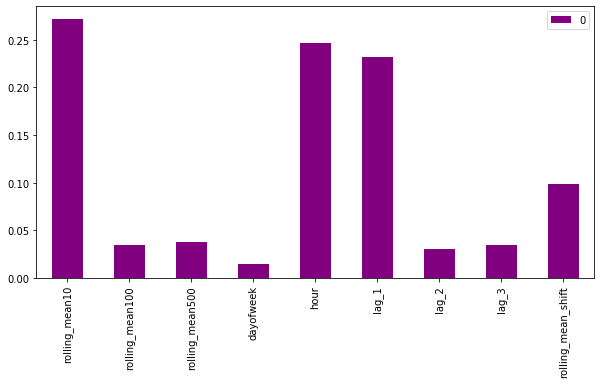

In [ ]:
model = RandomForestRegressor(random_state = 23)
model.fit(train.drop(['num_orders'], axis=1), train['num_orders'])
table = pd.DataFrame(model.feature_importances_, df.columns[1:])
table.plot(kind = 'bar', color = 'purple', figsize = (10,5))
None

Ожидаемо наиболее значимый признак - скользящее среднее, причём с окном в 10 часов и сдвиг на 1 единицу. Среди сезонных признаков, мы ранее видели на графиках наиболее очевидную связь числа заказов с часом, это подтверждается и значимостью данного фактора в уравнении регрессии. Предсказывать количество заказов на следующий час следуюет исходя из среднего для данного часа внутри суток: пики на утро до 11 часов, в райне 17 часов и в районе 12 ночи, что может быть связано с расписанием рейсов в данном аэропорту. Популярность такси анализируемого сервиса растёт, поэтому прогноз также учитывает данный тренд.